> This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.

In [210]:
library(tidyverse)
library(tidyquant)
library(modelr)
library(gridExtra)
library(grid)
library(ggthemes)

theme_update(plot.title = element_text(hjust = 0.5))

In [2]:
retail <- read_csv("data/data.csv",
                   col_types = cols(
                      InvoiceNo = col_character(),
                      StockCode = col_character(),
                      Description = col_character(),
                      Quantity = col_integer(),
                      InvoiceDate = col_datetime("%m/%d/%Y %H:%M"),
                      UnitPrice = col_double(),
                      CustomerID = col_integer(),
                      Country = col_character()
                      ))

In [6]:
retail$Description <- iconv(retail$Description, "ascii", "utf-8")

In [7]:
retail <- retail %>%
    rename(
        invoice_no = InvoiceNo,
        stock_code = StockCode,
        description = Description,
        quantity = Quantity,
        invoice_date = InvoiceDate,
        unit_price = UnitPrice,
        customer_id = CustomerID,
        country = Country
    )

In [8]:
head(retail)

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


In [9]:
retail <- retail %>%
    mutate(
        date = parse_date(format(invoice_date, "%Y-%m-%d")),
        day_of_week = wday(date, label = TRUE),
        time = parse_time(format(invoice_date, "%H:%M")),
        month = format(invoice_date, "%m"),
        income = quantity * unit_price,
        income_return = ifelse(quantity > 0, "income", "return")
    )

In [10]:
head(retail)

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,date,day_of_week,time,month,income,income_return
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,15.30,income
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,20.34,income
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,22.00,income
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,20.34,income
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,20.34,income
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,2010-12-01,Wed,08:26:00,12,15.30,income


In [11]:
dim(retail)

[1] 541909     14

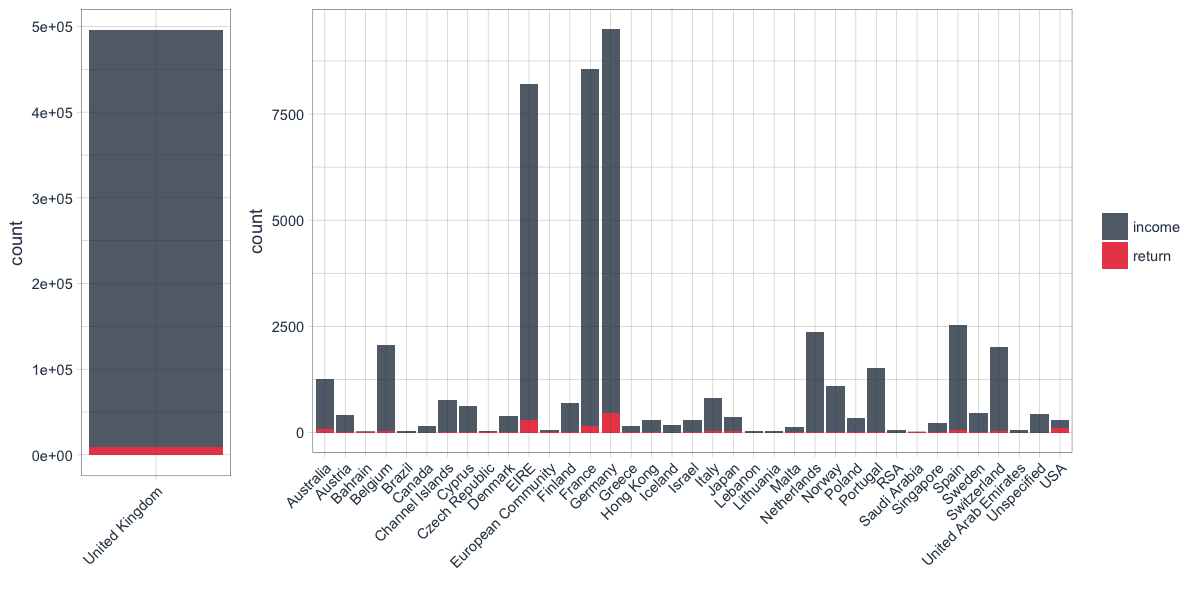

In [12]:
options(repr.plot.width=10, repr.plot.height=5)

p1 <- retail %>%
  filter(country == "United Kingdom") %>%
  ggplot(aes(x = country, fill = income_return)) +
    geom_bar(alpha = 0.8) +
    scale_fill_manual(values = palette_light()) +
    theme_tq() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    guides(fill = FALSE) +
    labs(x = "")

p2 <- retail %>%
  filter(country != "United Kingdom") %>%
  ggplot(aes(x = country, fill = income_return)) +
    geom_bar(alpha = 0.8) +
    scale_fill_manual(values = palette_light()) +
    theme_tq() +
    theme(legend.position = "right") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    labs(x = "",
         fill = "")

grid.arrange(p1, p2, widths = c(0.2, 0.8))

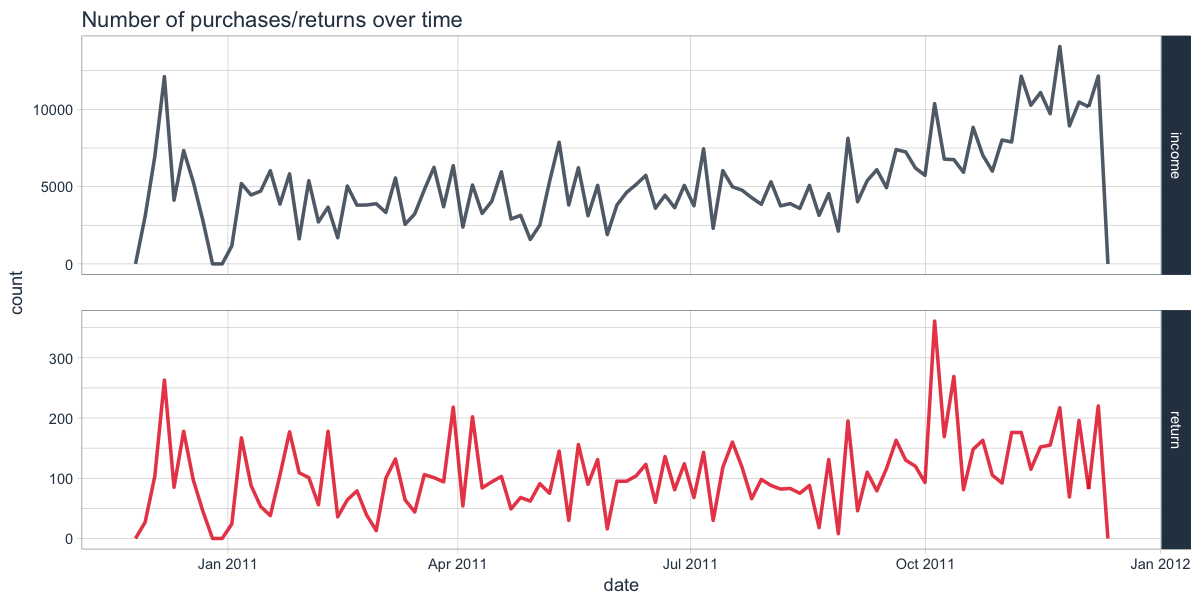

In [13]:
retail %>%
  ggplot(aes(x = date, color = income_return)) +
    facet_grid(income_return ~ ., scales = "free") +
    geom_freqpoly(bins = 100, size = 1, alpha = 0.8) +
    scale_color_manual(values = palette_light()) +
    theme_tq() +
    guides(color = FALSE) +
    labs(title = "Number of purchases/returns over time", bx = "")

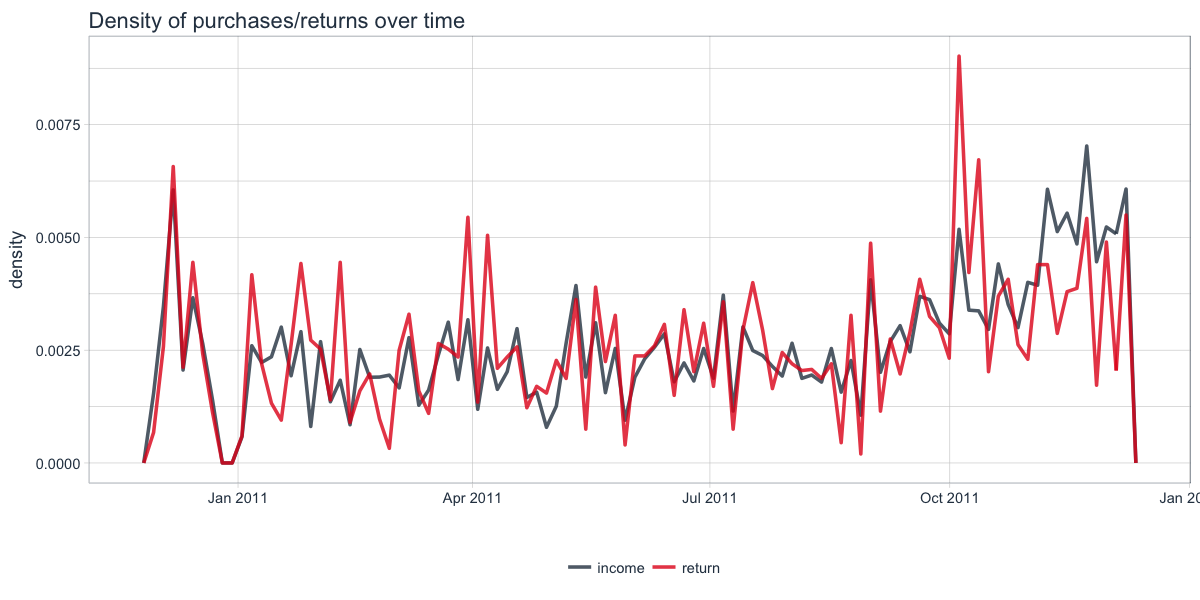

In [14]:
retail %>%
  ggplot(aes(x = date, y = ..density.., color = income_return)) +
    geom_freqpoly(size = 1, alpha = 0.8, bins = 100) +
    scale_color_manual(values = palette_light()) +
    theme_tq() +
    labs(title = "Density of purchases/returns over time",
         x = "",
         color = "")

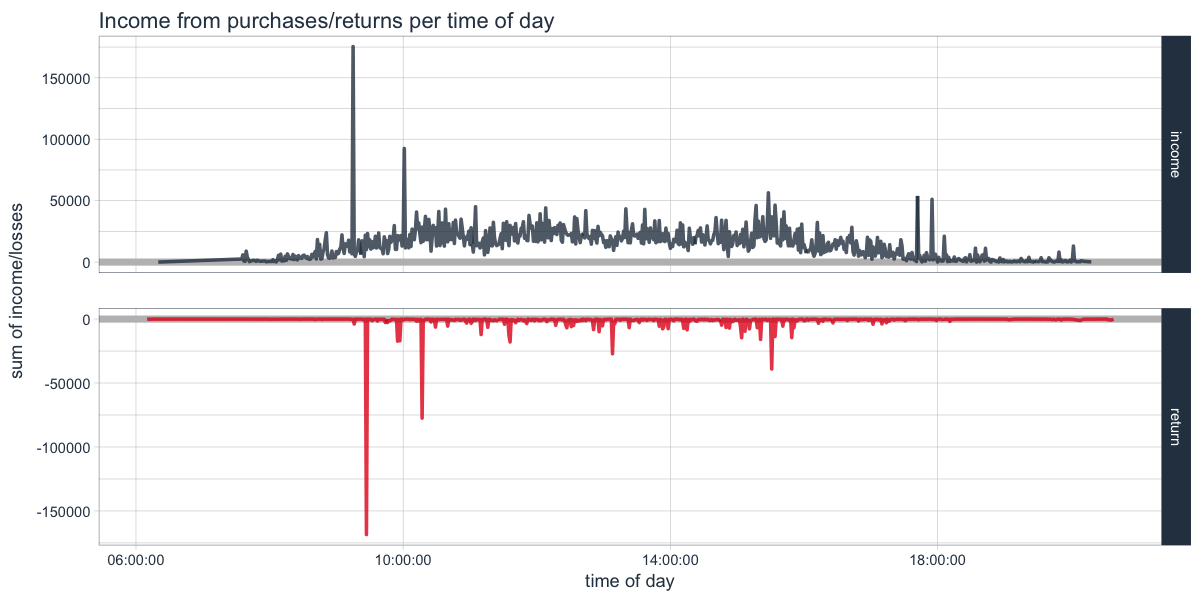

In [15]:
retail %>%
  group_by(time, income_return) %>%
  summarise(sum_income = sum(income)) %>%
  ggplot(aes(x = time, y = sum_income, color = income_return)) +
    facet_grid(income_return ~ ., scales = "free") +
    geom_ref_line(h = 0, colour = "grey") +
    geom_line(size = 1, alpha = 0.8) +
    scale_color_manual(values = palette_light()) +
    theme_tq() +
    guides(color = FALSE) +
    labs(title = "Income from purchases/returns per time of day",
         x = "time of day",
         y = "sum of income/losses",
         color = "")

In [16]:
retail %>%
  filter(date == "2011-12-09") %>%
  arrange(-quantity) %>%
  .[1:3, ]

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,date,day_of_week,time,month,income,income_return
581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,2011-12-09,Fri,09:15:00,12,168469.60,income
581476,16008,SMALL FOLDING SCISSOR(POINTED EDGE),240,2011-12-09 08:48:00,0.12,12433,Norway,2011-12-09,Fri,08:48:00,12,28.80,income
581476,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,192,2011-12-09 08:48:00,1.06,12433,Norway,2011-12-09,Fri,08:48:00,12,203.52,income


In [17]:
retail %>%
  filter(date == "2011-12-09") %>%
  arrange(quantity) %>%
  .[1:3, ]

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,date,day_of_week,time,month,income,income_return
C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom,2011-12-09,Fri,09:27:00,12,-168469.60,return
C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom,2011-12-09,Fri,09:57:00,12,-23.40,return
C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,2011-12-09,Fri,09:57:00,12,-9.13,return


In [18]:
retail %>%
  filter(customer_id == 16446)

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,date,day_of_week,time,month,income,income_return
553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom,2011-05-18,Wed,09:52:00,05,1.65,income
553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom,2011-05-18,Wed,09:52:00,05,1.25,income
581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,2011-12-09,Fri,09:15:00,12,168469.60,income
C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom,2011-12-09,Fri,09:27:00,12,-168469.60,return


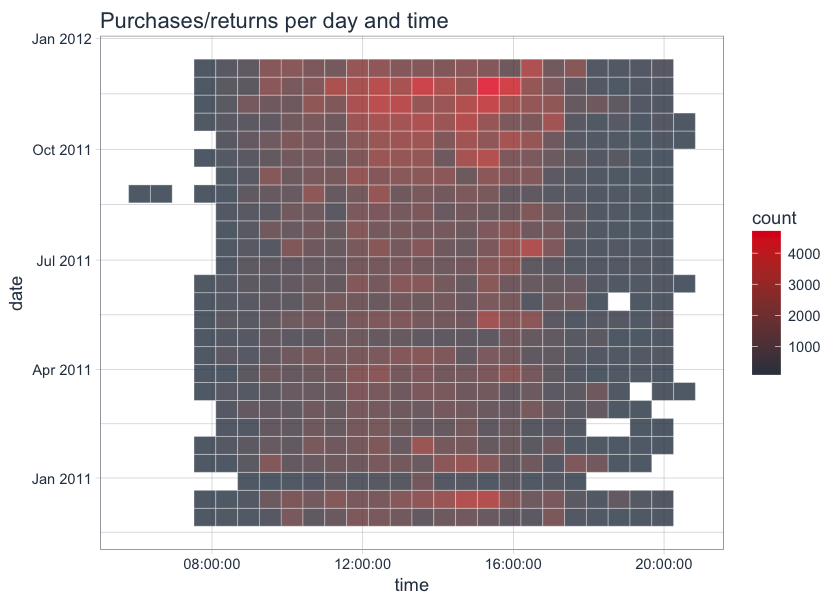

In [19]:
options(repr.plot.width=7, repr.plot.height=5)

retail %>%
  ggplot(aes(x = time, y = date)) +
    stat_bin2d(alpha = 0.8, bins = 25, color = "white") +
    scale_fill_gradientn(colours = c(palette_light()[[1]], palette_light()[[2]])) +
    theme_tq() +
    theme(legend.position = "right") +
    labs(title = "Purchases/returns per day and time")

# Purchased Items

In [34]:
item_purchases <- retail %>%
    group_by(stock_code, description) %>%
    summarise(times_bought = sum(quantity)) %>%
    ungroup

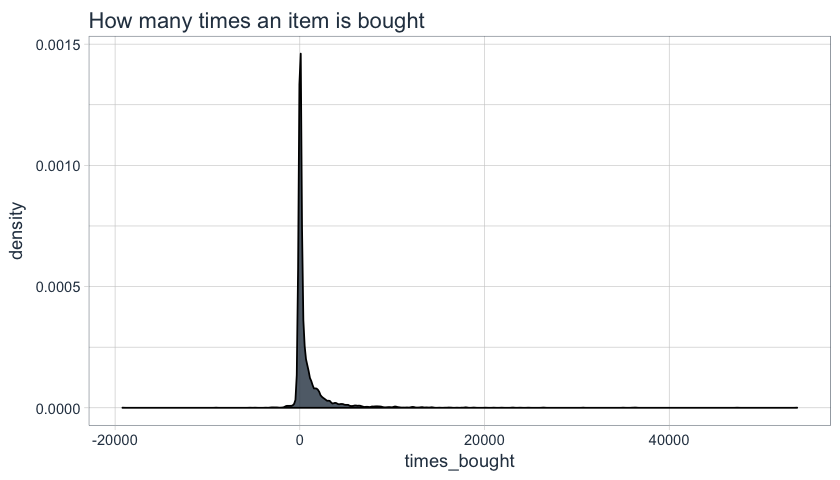

In [168]:
options(repr.plot.width=7, repr.plot.height=4)

item_purchases %>%
  ggplot(aes(x = times_bought)) +
    geom_density(fill = palette_light()[[1]], alpha = 0.8) +
    labs(title = "How many times an item is bought") +
    theme_tq()

In [40]:
item_purchases %>%
    arrange(-times_bought) %>%
    slice(1:20)

stock_code,description,times_bought
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
85099B,JUMBO BAG RED RETROSPOT,47363
84879,ASSORTED COLOUR BIRD ORNAMENT,36381
22197,POPCORN HOLDER,36334
21212,PACK OF 72 RETROSPOT CAKE CASES,36039
85123A,WHITE HANGING HEART T-LIGHT HOLDER,35025
23084,RABBIT NIGHT LIGHT,30680
22492,MINI PAINT SET VINTAGE,26437
22616,PACK OF 12 LONDON TISSUES,26315
21977,PACK OF 60 PINK PAISLEY CAKE CASES,24753


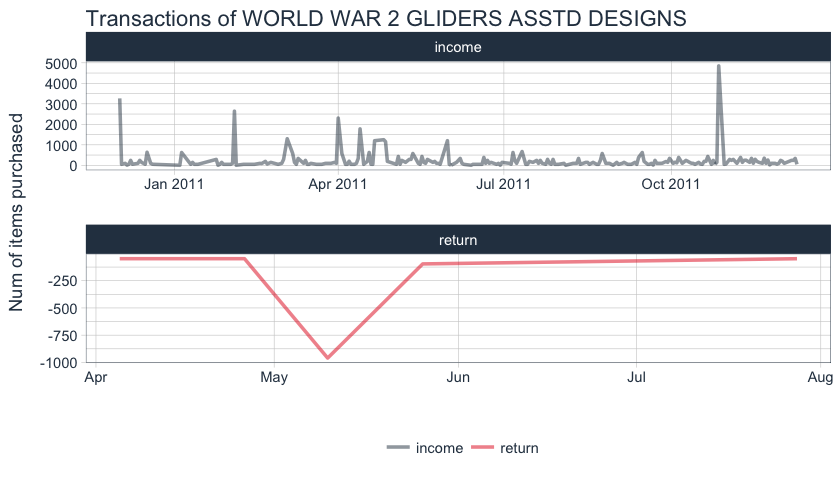

In [45]:
retail %>%
  filter(stock_code == "84077") %>%
  group_by(date, income_return) %>%
  summarise(sum = sum(quantity)) %>%
  ggplot(aes(x = date, y = sum, color = income_return)) +
    facet_wrap(~ income_return, ncol = 1, scales = "free") +
    geom_line(size = 1, alpha = 0.5) +
    scale_color_manual(values = palette_light()) +
    theme_tq() +
    labs(x = "",
         y = "Num of items purchased",
         color = "",
         title = "Transactions of WORLD WAR 2 GLIDERS ASSTD DESIGNS")

# Customers

In [150]:
customer_days_bought <- retail %>%
    group_by(date, customer_id) %>%
    summarise(n = n()) %>%
    group_by(customer_id) %>%
    summarise(times_bought = n()) %>%
    group_by(times_bought) %>%
    summarise(n_customer = n())

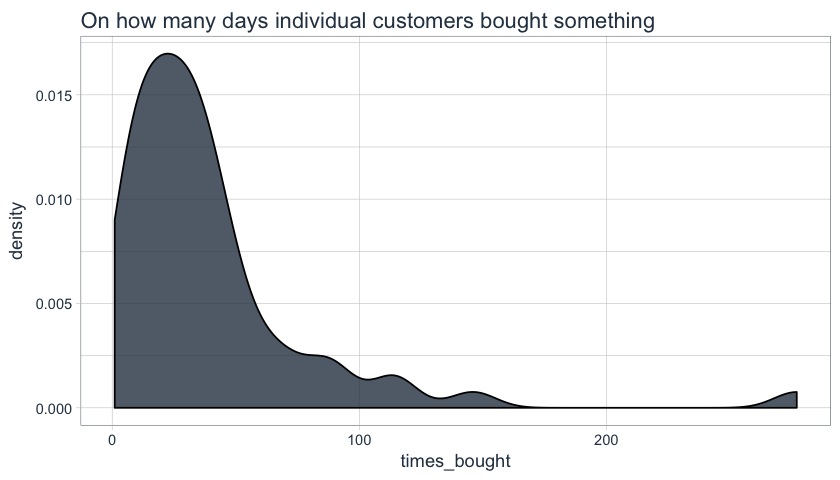

In [169]:
ggplot(customer_days_bought, aes(x = times_bought)) +
    geom_density(fill = palette_light()[[1]], alpha = 0.8) +
    labs(title = "On how many days individual customers bought something") +
    theme_tq()

In [185]:
one_time_customer <- customer_days_bought %>% slice(1) %>% select(n_customer)
repeat_customer <- customer_days_bought %>% slice(2:n()) %>% summarise(n_customer = sum(n_customer))

In [195]:
one_time_prop <- one_time_customer$n_customer / (one_time_customer$n_customer + repeat_customer$n_customer)
repeat_prop <- 1.0 - one_time_prop

In [201]:
repeat_data <- tibble(
    customer_type=c("one time", "repeat"),
    prop=c(one_time_prop, repeat_prop)
)

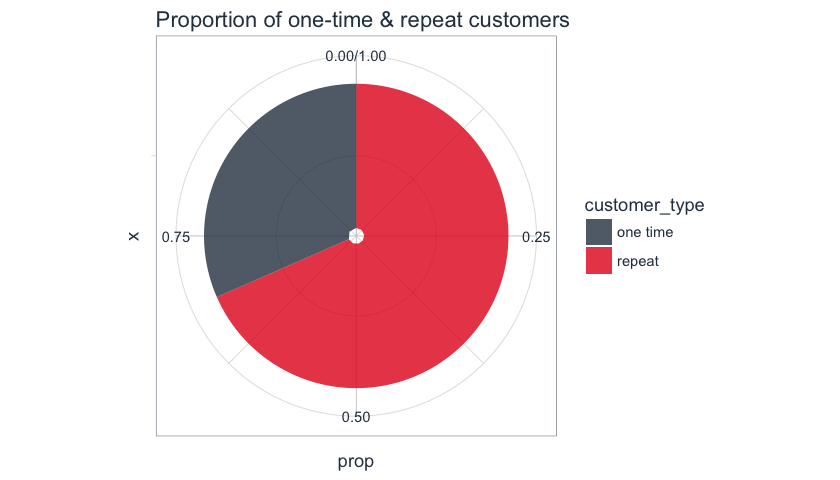

In [203]:
ggplot(repeat_data, aes(x = "", y = prop, fill = customer_type)) +
    geom_bar(stat = "identity", alpha = 0.8) +
    coord_polar("y", start = 0) +
    scale_fill_manual(values = palette_light()) +
    labs(title = "Proportion of one-time & repeat customers") +
    theme_tq() +
    theme(legend.position = "right")

# Net income and quantities sold

In [205]:
income <- retail %>%
  group_by(date) %>%
  summarise(sum_income = sum(income),
            mean_income = mean(income),
            sum_quantity = sum(quantity),
            mean_quantity = mean(quantity))

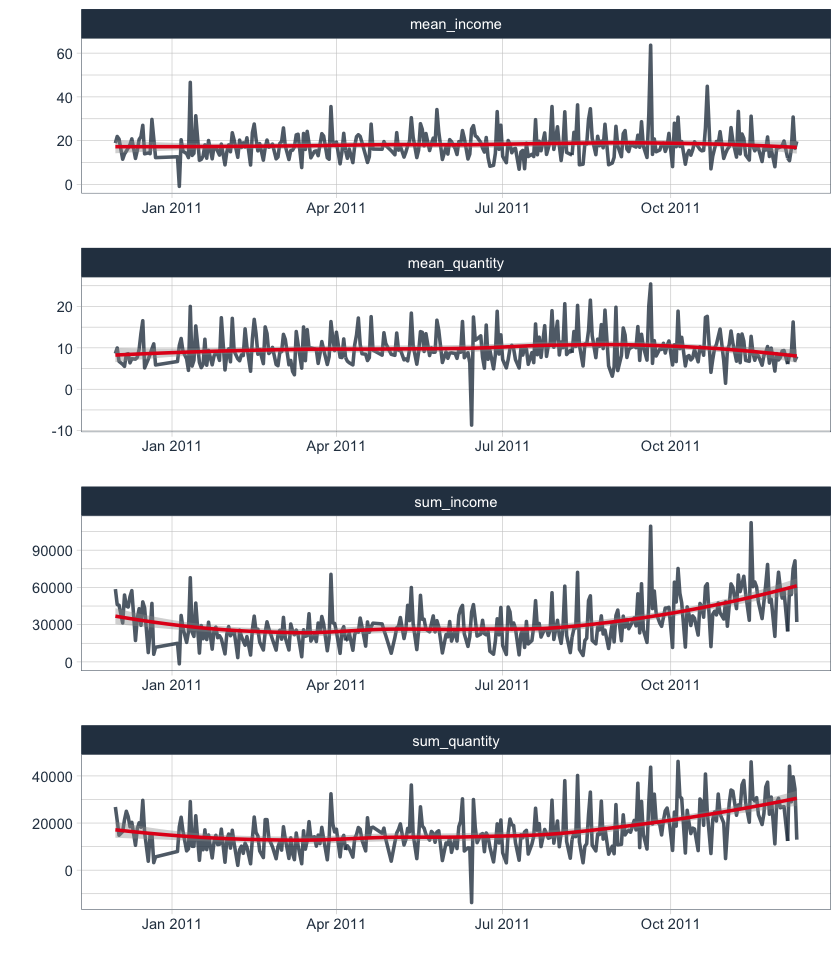

In [209]:
options(repr.plot.width=7, repr.plot.height=8)

income %>%
  gather(x, y, sum_income:mean_quantity) %>%
  ggplot(aes(x = date, y = y)) +
    facet_wrap(~ x, ncol = 1, scales = "free") +
    geom_line(color = palette_light()[[1]], size = 1, alpha = 0.8) +
    geom_smooth(color = palette_light()[[2]], method = 'loess') +
    theme_tq() +
    labs(x = "", 
         y = "")